📚 **Importar librerías**

In [1]:
# librerías base para data science
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# configuración para que solo se muestren 2 decimales
pd.set_option("display.float_format", "{:.2f}".format)

💾 **Cargar datos**

In [3]:
BASE_DIR = Path("/home/lof/Projects/Telco-Customer-Churn")
DATA_DIR = BASE_DIR / "data" / "interim"
churn_df = pd.read_parquet(
    DATA_DIR / "churn_type_fixed.parquet", engine="pyarrow")

📊 **Descripción del dataframe**

In [4]:
# información general
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24742 entries, 0 to 24741
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MonthlyCharges    24527 non-null  float64 
 1   StreamingMovies   24415 non-null  category
 2   Partner           24742 non-null  bool    
 3   PhoneService      24742 non-null  bool    
 4   InternetService   24445 non-null  category
 5   StreamingTV       24375 non-null  category
 6   OnlineSecurity    24393 non-null  category
 7   MultipleLines     24493 non-null  category
 8   Dependents        24742 non-null  bool    
 9   DeviceProtection  24383 non-null  category
 10  SeniorCitizen     24742 non-null  bool    
 11  TotalCharges      24560 non-null  float64 
 12  TechSupport       24379 non-null  category
 13  gender            24684 non-null  category
 14  PaperlessBilling  24742 non-null  bool    
 15  tenure            24562 non-null  float64 
 16  Churn             2474

In [5]:
# tamaño del dataframe
churn_df.shape

(24742, 20)

In [6]:
# algunos registros
churn_df.sample(5)

,MonthlyCharges,StreamingMovies,Partner,PhoneService,InternetService,StreamingTV,OnlineSecurity,MultipleLines,Dependents,DeviceProtection,SeniorCitizen,TotalCharges,TechSupport,gender,PaperlessBilling,tenure,Churn,OnlineBackup,PaymentMethod,Contract
21470,105.20,Yes,False,True,Fiber optic,Yes,Yes,No,True,No,False,4822.85,Yes,Female,True,46.00,True,Yes,Bank transfer (automatic),One year
15568,18.90,No internet service,False,True,No,No internet service,No internet service,No,False,No internet service,False,347.65,No internet service,Female,True,20.00,False,No internet service,Credit card (automatic),Month-to-month
19512,29.75,No,False,False,DSL,No,Yes,No phone service,False,No,False,301.90,No,Female,False,10.00,False,No,Mailed check,Month-to-month
11054,38.55,No,True,False,DSL,No,Yes,No phone service,True,Yes,False,280.00,No,Male,False,7.00,False,Yes,Mailed check,Two year
15543,83.70,Yes,False,True,DSL,Yes,No,Yes,True,Yes,False,2633.30,Yes,Male,False,32.00,False,Yes,Credit card (automatic),One year


In [7]:
def convert_bool_to_category(df):
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype('category')
    return df

# Aplicación en el DataFrame
#churn_df = convert_bool_to_category(churn_df)

Necesitamos convertir todas las columnas que eran booleanas a categoricas para su debido analisis 

In [8]:
nulls_perc = (churn_df.isnull().sum() / len(churn_df) * 100).round(2)

pd.DataFrame({
    "Null count" : churn_df.isnull().sum(),
    "Null %" : nulls_perc,
    "Dtype": churn_df.dtypes
}) 

,Null count,Null %,Dtype
MonthlyCharges,215,0.87,float64
StreamingMovies,327,1.32,category
Partner,0,0.00,bool
PhoneService,0,0.00,bool
InternetService,297,1.20,category
StreamingTV,367,1.48,category
OnlineSecurity,349,1.41,category
MultipleLines,249,1.01,category
Dependents,0,0.00,bool
DeviceProtection,359,1.45,category


No hay un número de valores nulos representativos dentro de las columnas para descartar una de ellas

Variable target: **'Churn'**

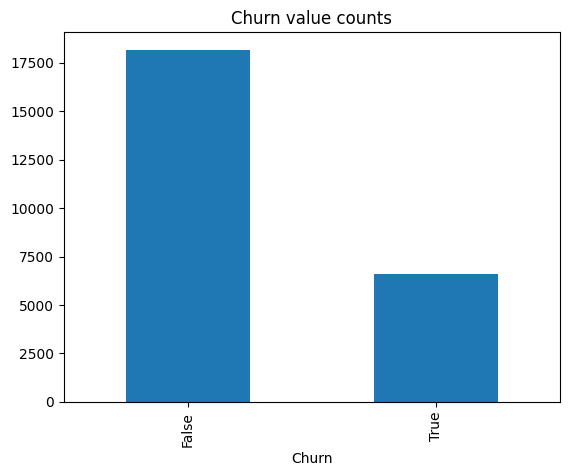

In [9]:
churn_df['Churn'].value_counts().plot(
        kind="bar", title = f"Churn value counts"
    )
plt.show()

Antes de entrar a analizar las variables debemos observar si existen registros duplicados que nos puedan mostrar un analisis incorrecto del dataset

In [10]:
churn_df.duplicated().sum()

np.int64(17830)

El total de datos de este dataset es 24742 y el valor de los registros duplicados es más de la mitad, por lo cual los eliminaremos antes de comenzar el analisis

In [11]:
churn_df.drop_duplicates(inplace=True, keep="first")
churn_df.duplicated().sum() # Comprobación de existencia de duplicados

np.int64(0)

Ahora investigaremos los outliers para lograr tener un analisis más adecuado

In [12]:
churn_df.describe()

,MonthlyCharges,TotalCharges,tenure
count,6836.00,6859.00,6851.00
mean,767391474.51,792199942.67,32.47
std,63417377053.06,65728553144.59,24.49
min,18.25,-9876543456.00,0.00
25%,35.69,411.93,9.00
50%,70.35,1411.35,29.00
75%,89.85,3805.88,55.00
max,5243355243554.00,5443567897654.00,72.00


Es evidente que las columnas 'MonthlyCharges' y 'TotalCharges' tienen valores atipicos ya que no pueden haber cobros negativos ni cargos mensuales mayores de por lo menos 1.000 USD, debemos hacernos cargo de estos outliers o nos darán problemas luego en nuestro analisis

In [13]:
# Contar los datos que NO cumplen las condiciones dadas
num_outliers = churn_df.shape[0] - churn_df[
    (churn_df["MonthlyCharges"] > 0) & (churn_df["MonthlyCharges"] < 500) &
    (churn_df["TotalCharges"] > 0) & (churn_df["TotalCharges"] < 20000)
].shape[0]

print(f"Número de registros que NO cumplen las condiciones {num_outliers} de {churn_df.shape[0]} posibles")

Número de registros que NO cumplen las condiciones 98 de 6912 posibles


Este valor representa el 1% del total de los datos, pero no los eliminaré, los pondré como np.nan para posteriormente hacer una imputación por KNN ya que son cuentas de cobro de acuerdo a los servicios prestados de una empresa de comunicaciones, por lo que sería de alguna forma fácil estimar el valor de los vcargos de acuerdo a los servicios que tengan

In [14]:
# Reemplazar los valores fuera de rango por np.nan
churn_df.loc[
    ~((churn_df["MonthlyCharges"] > 0) & (churn_df["MonthlyCharges"] < 500) &
      (churn_df["TotalCharges"] > 0) & (churn_df["TotalCharges"] < 20000)),
    ["MonthlyCharges", "TotalCharges"]
] = np.nan

# Verificar cuántos valores NaN quedaron
print(churn_df.isna().sum())

MonthlyCharges       98
StreamingMovies     128
Partner               0
PhoneService          0
InternetService     113
StreamingTV         144
OnlineSecurity      139
MultipleLines        92
Dependents            0
DeviceProtection    142
SeniorCitizen         0
TotalCharges         98
TechSupport         143
gender                3
PaperlessBilling      0
tenure               61
Churn                 0
OnlineBackup        145
PaymentMethod        85
Contract             84
dtype: int64


### 📈 **Análisis univariable**

**Variables númericas**

In [15]:
# list of the numerical columns
numerical_columns = list(churn_df.select_dtypes(include=["number"]).columns)
numerical_columns

['MonthlyCharges', 'TotalCharges', 'tenure']

In [16]:
churn_df.describe()

,MonthlyCharges,TotalCharges,tenure
count,6814.00,6814.00,6851.00
mean,64.83,2284.47,32.47
std,30.06,2257.94,24.49
min,18.25,18.80,0.00
25%,35.75,411.49,9.00
50%,70.38,1405.65,29.00
75%,89.85,3799.84,55.00
max,118.75,8684.80,72.00


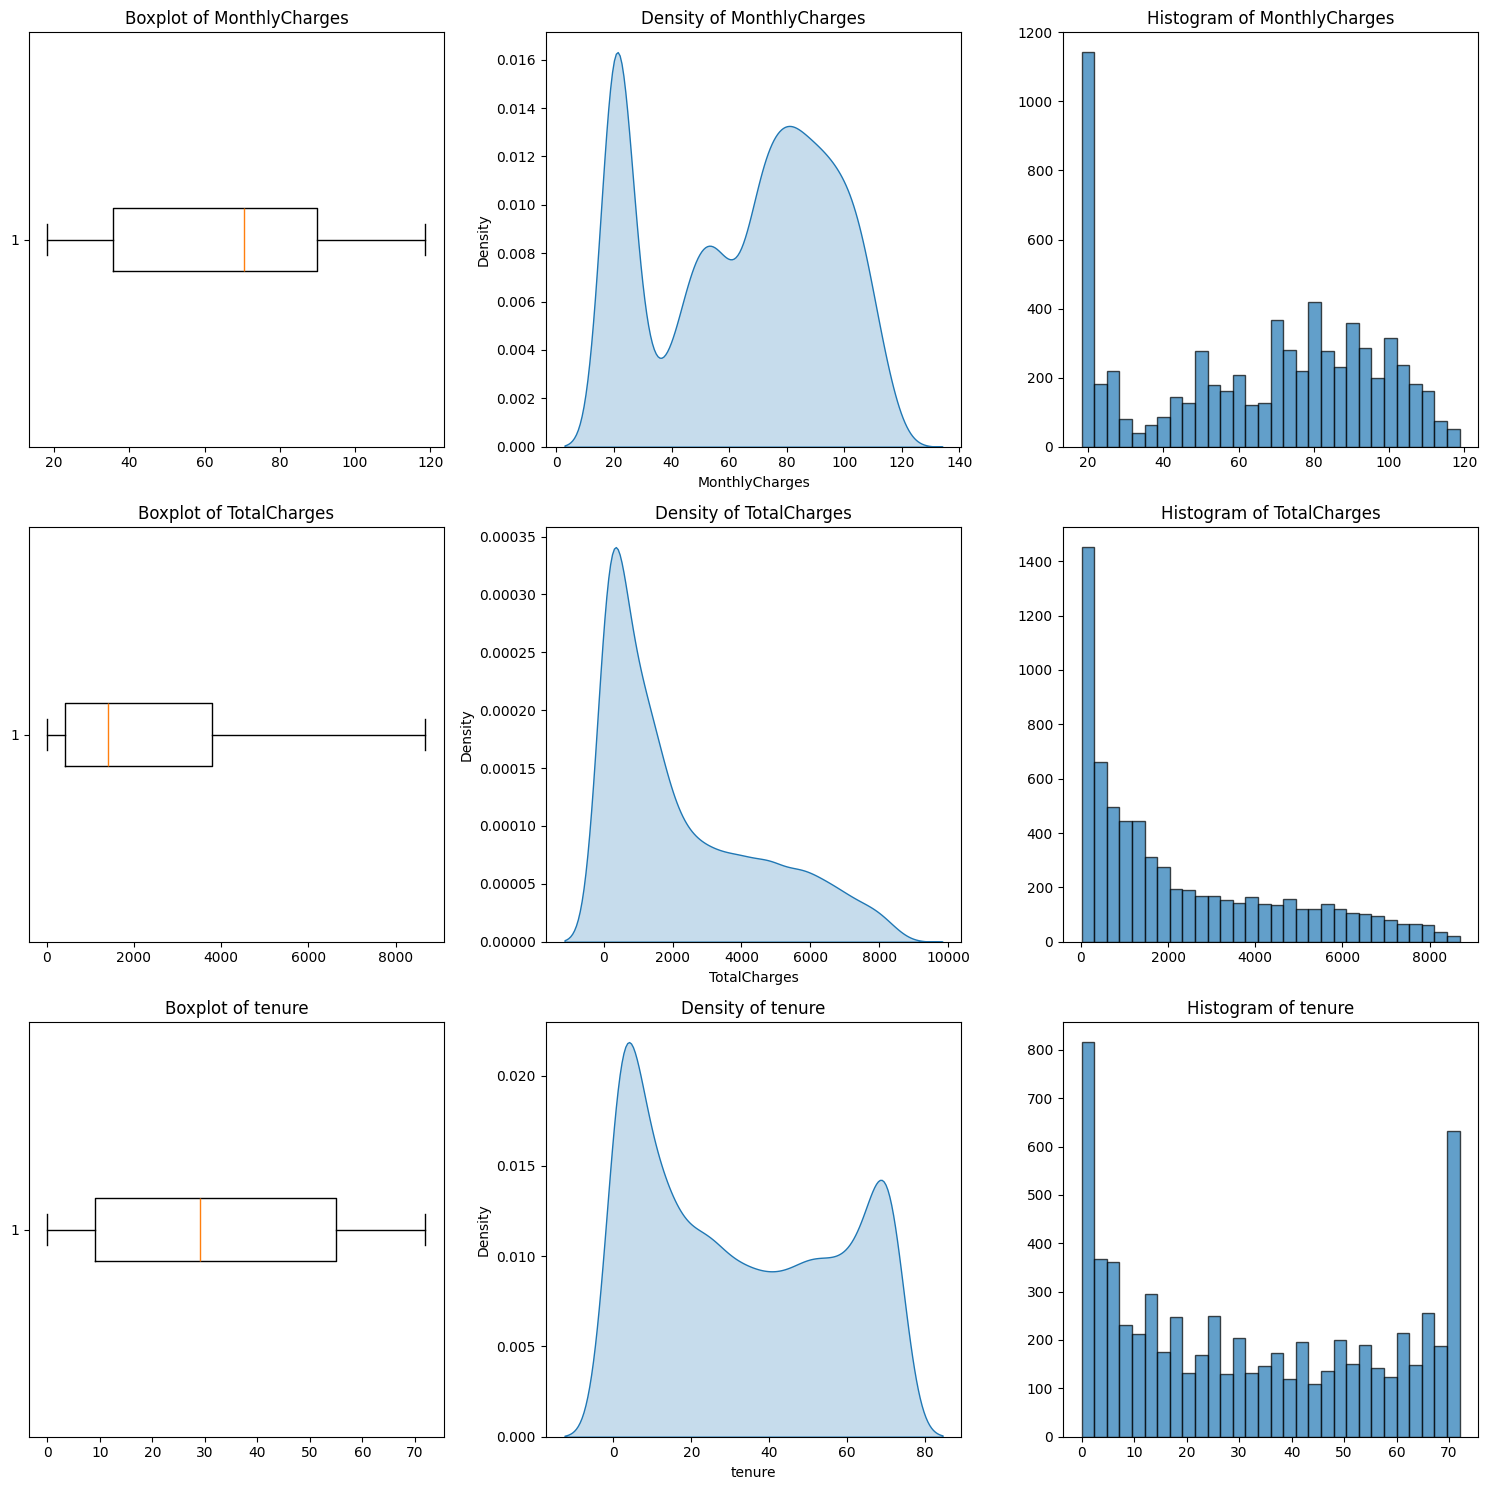

In [17]:
num_cols = list(churn_df.select_dtypes(include=["number"]).columns)

fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    axes[i, 0].boxplot(churn_df[col].dropna(), vert=False)
    axes[i, 0].set_title(f"Boxplot of {col}")

    # Density plot (approximation using histogram)
    sns.kdeplot(churn_df[col], fill=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Density of {col}")

    # Histogram
    axes[i, 2].hist(churn_df[col].dropna(), bins=30, edgecolor="black", alpha=0.7)
    axes[i, 2].set_title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

**Variables categoricas**

In [18]:
# descripción de columnas categoricas
churn_df.describe(include="category")

,StreamingMovies,InternetService,StreamingTV,OnlineSecurity,MultipleLines,DeviceProtection,TechSupport,gender,OnlineBackup,PaymentMethod,Contract
count,6784,6799,6768,6773,6820,6770,6769,6909,6767,6827,6828
unique,4,3,4,3,4,4,3,2,3,4,3
top,No,Fiber optic,No,No,No,No,No,Male,No,Electronic check,Month-to-month
freq,2684,2978,2694,3352,3272,2971,3322,3502,2962,2289,3739


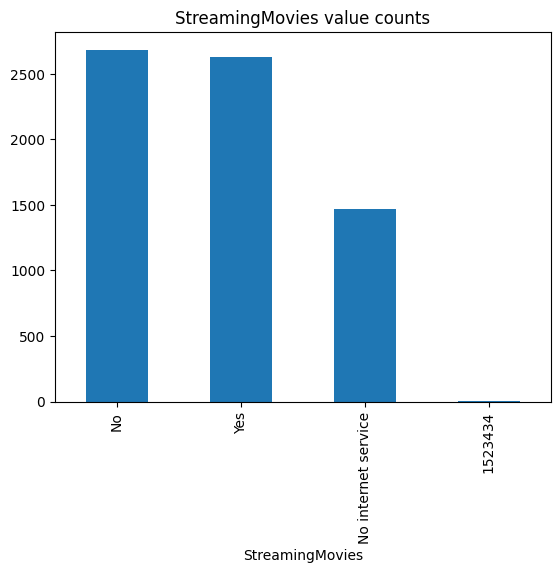

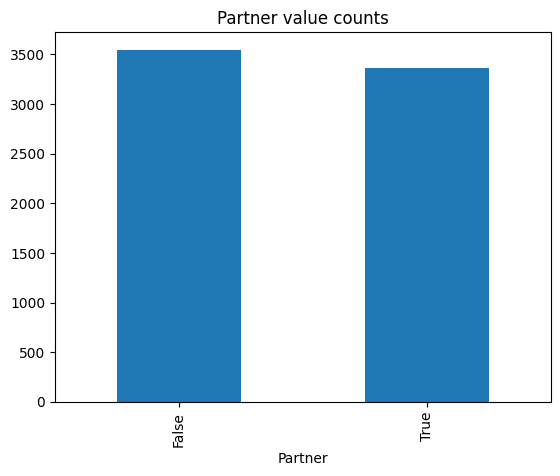

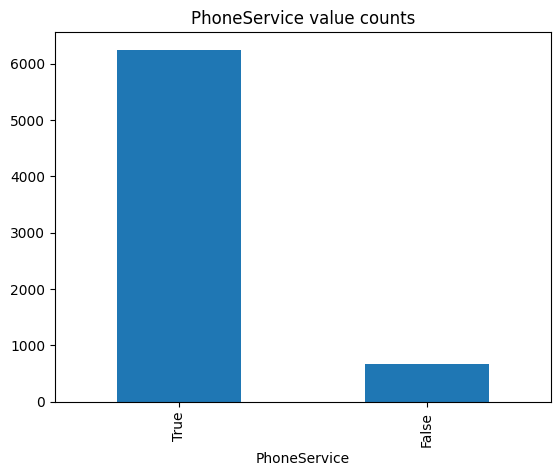

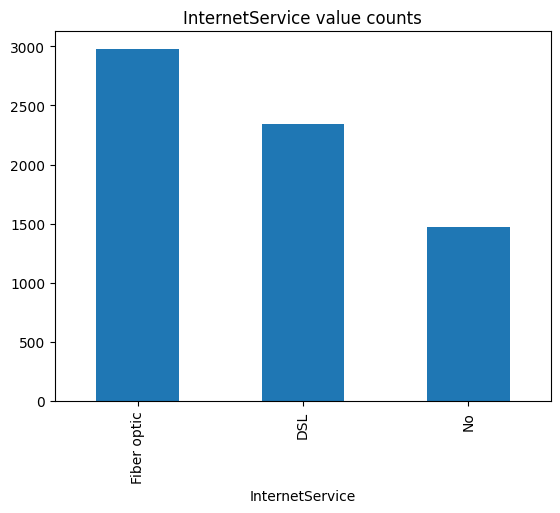

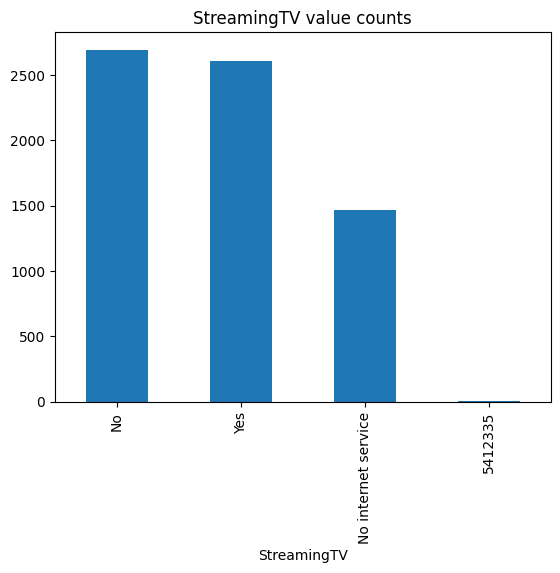

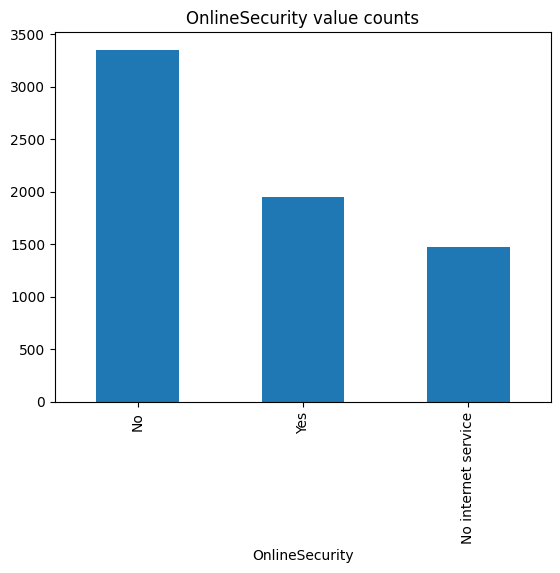

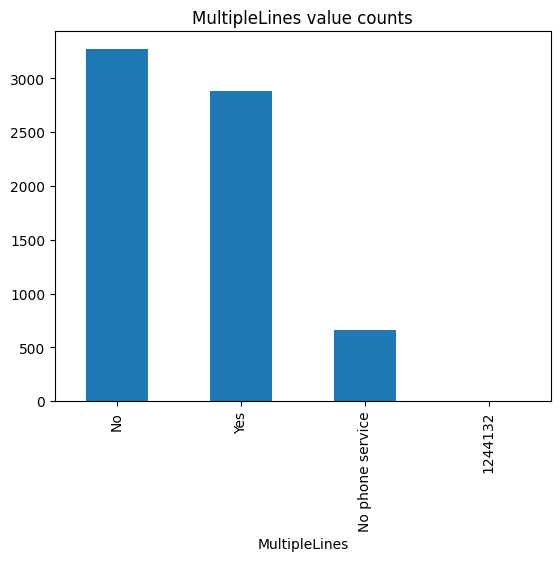

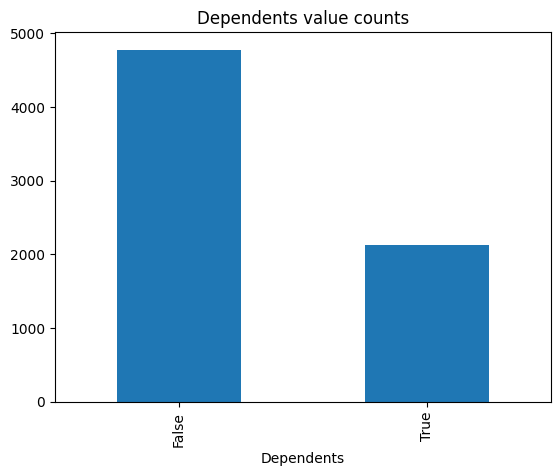

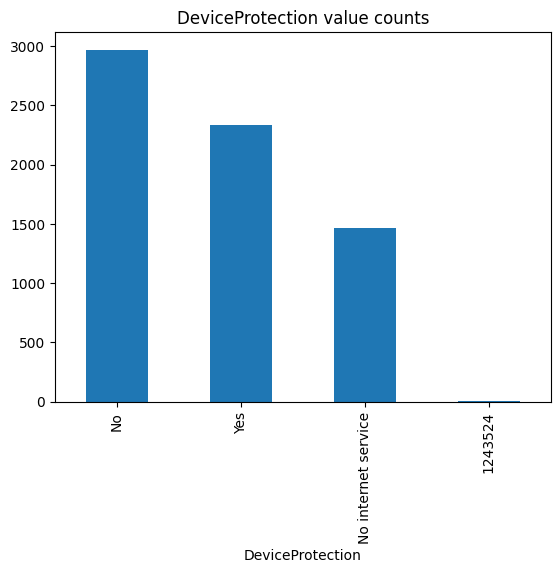

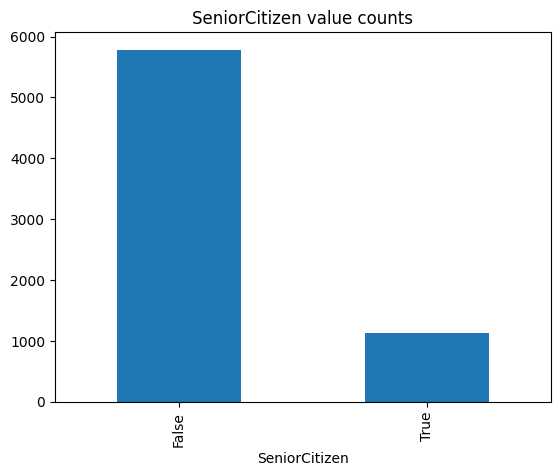

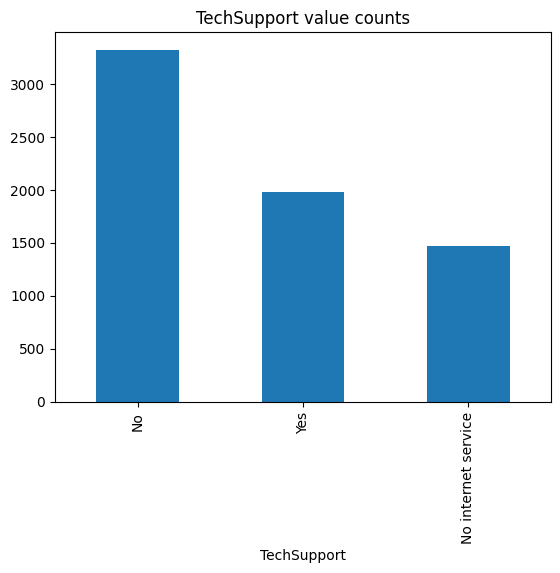

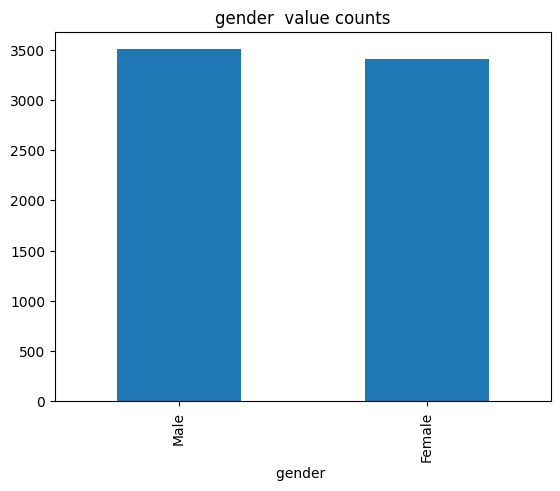

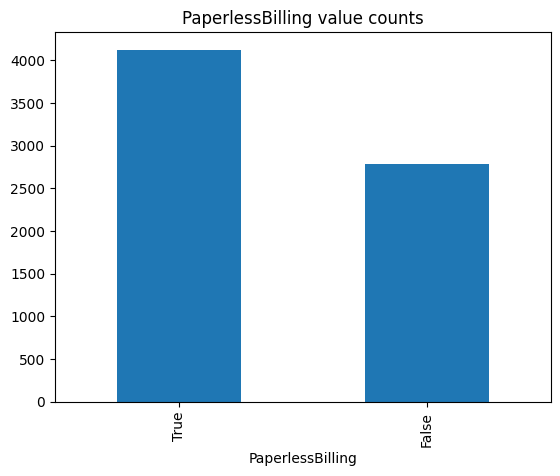

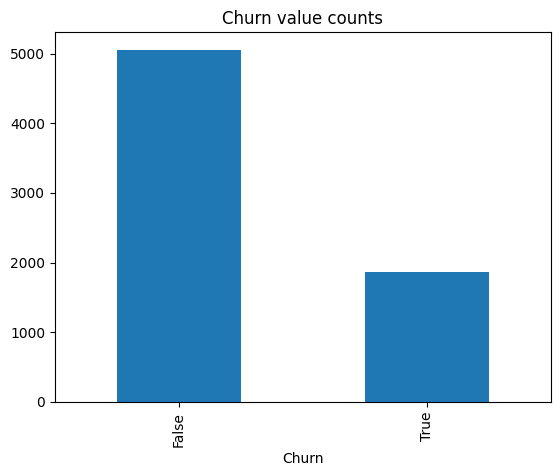

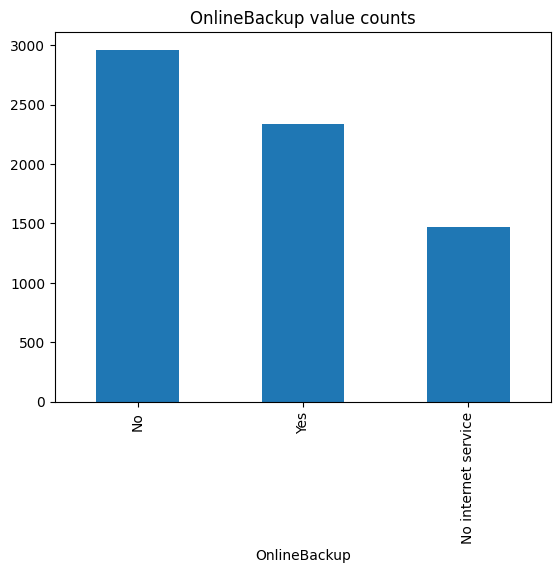

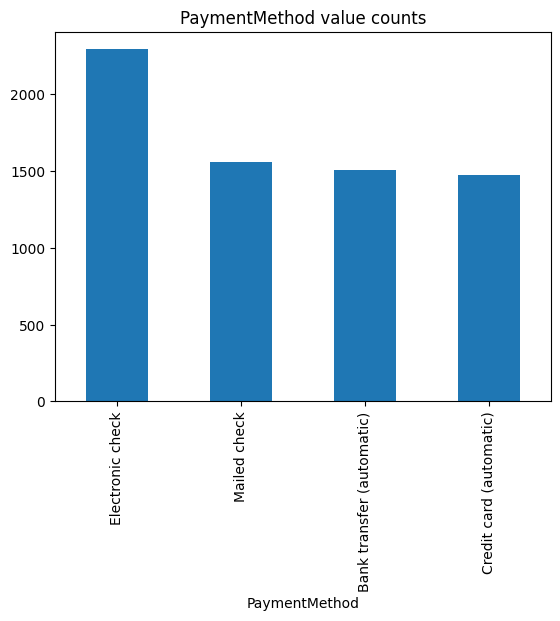

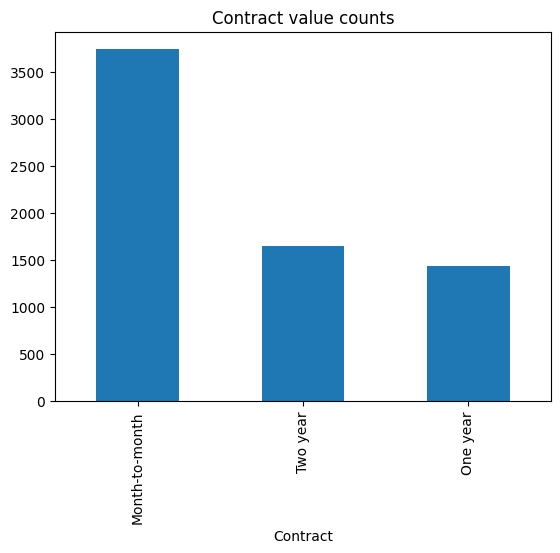

In [19]:
cat_cols = list(churn_df.select_dtypes(include=["object", "category", "bool"]).columns)

for col in cat_cols:
    churn_df[col].value_counts().plot(
        kind="bar", title = f"{col} value counts"
    )
    plt.show()

### 📈 **Bivariate Analysis**

Es importante revisar la relación entre la variable target y las otras variables

**Target vs Variables Numericas**

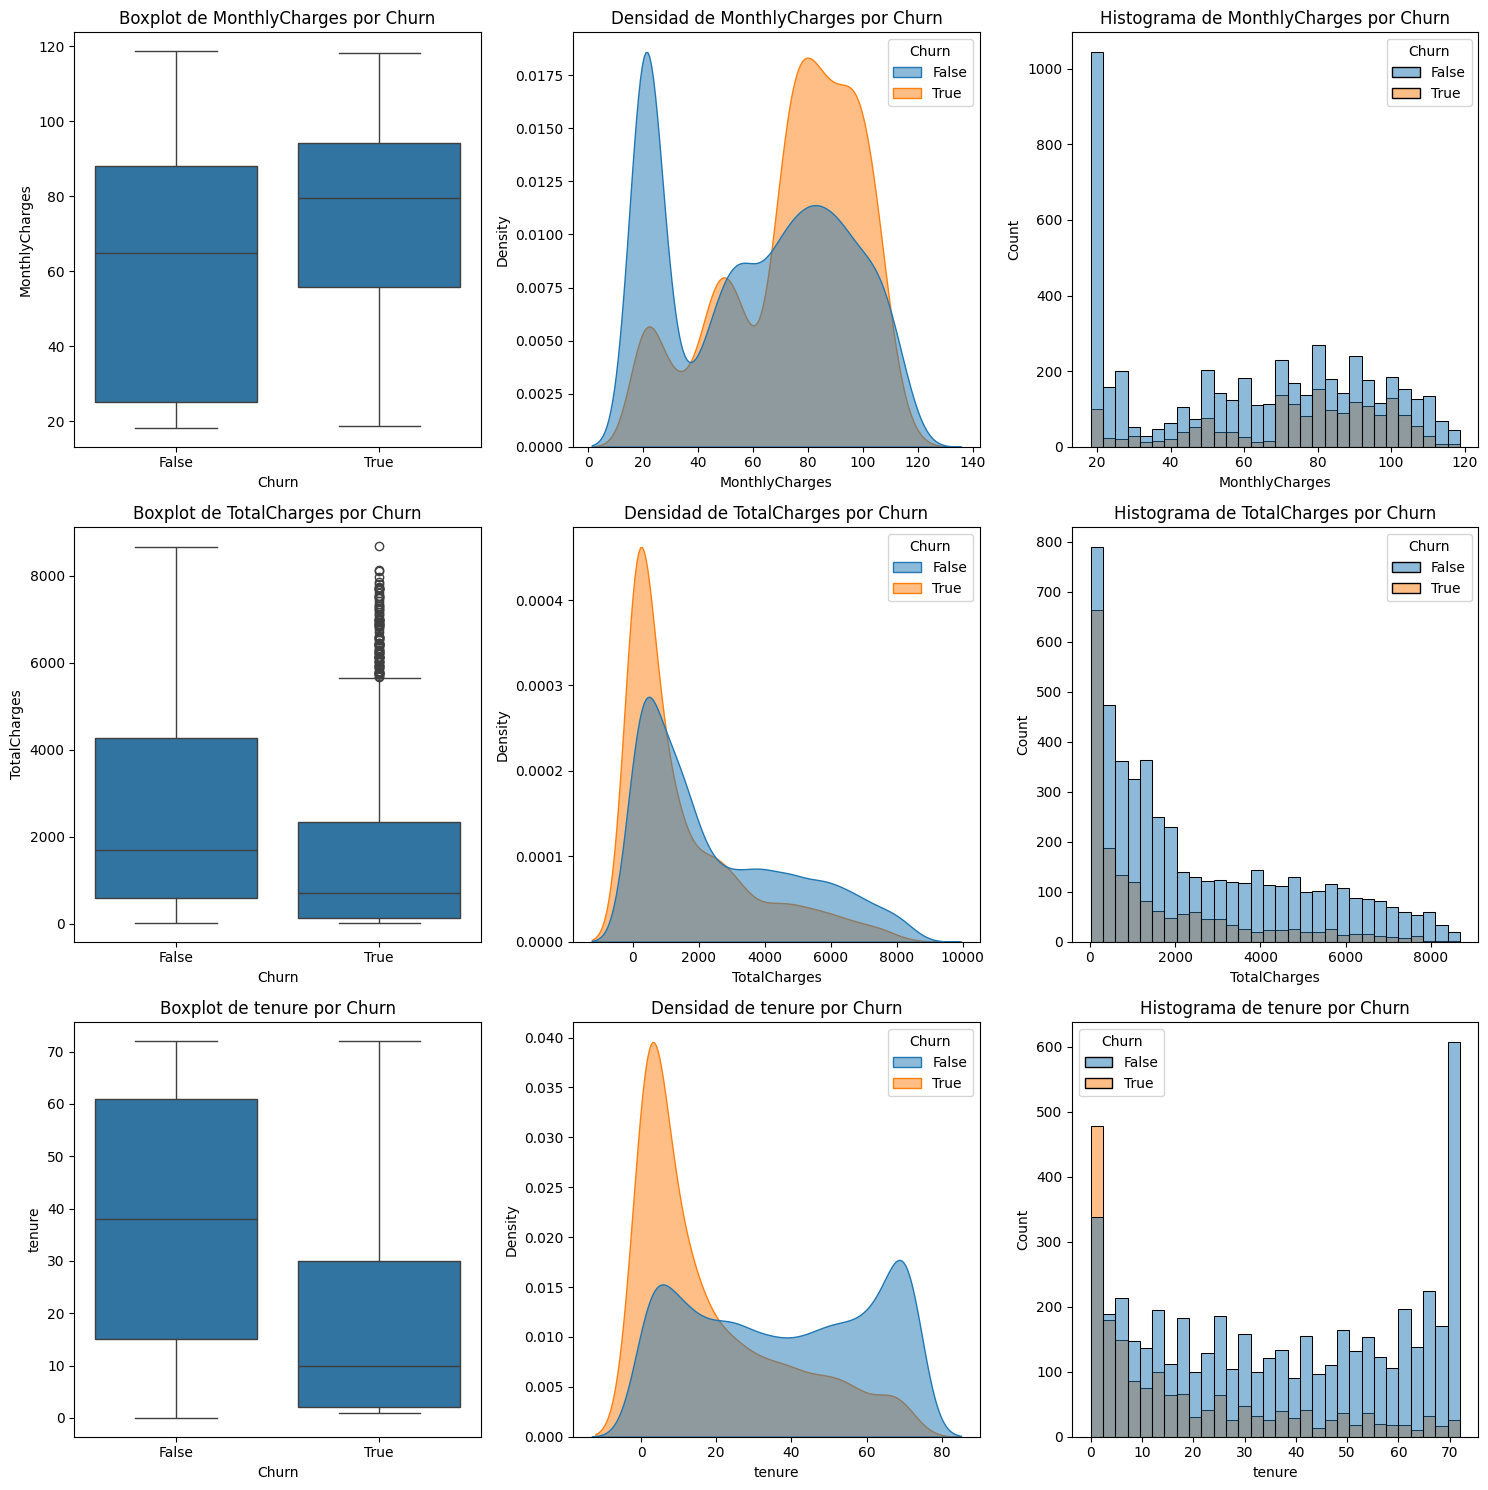

In [20]:
fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.boxplot(x="Churn", y=col, data=churn_df, ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot de {col} por Churn")
    
    sns.kdeplot(data=churn_df, x=col, hue="Churn", fill=True, common_norm=False, alpha=0.5, ax=axes[i, 1])
    axes[i, 1].set_title(f"Densidad de {col} por Churn")
    
    sns.histplot(data=churn_df, x=col, hue="Churn", bins=30, kde=False, alpha=0.5, ax=axes[i, 2])
    axes[i, 2].set_title(f"Histograma de {col} por Churn")

plt.tight_layout()
plt.show()

**Target vs Variables categoricas**

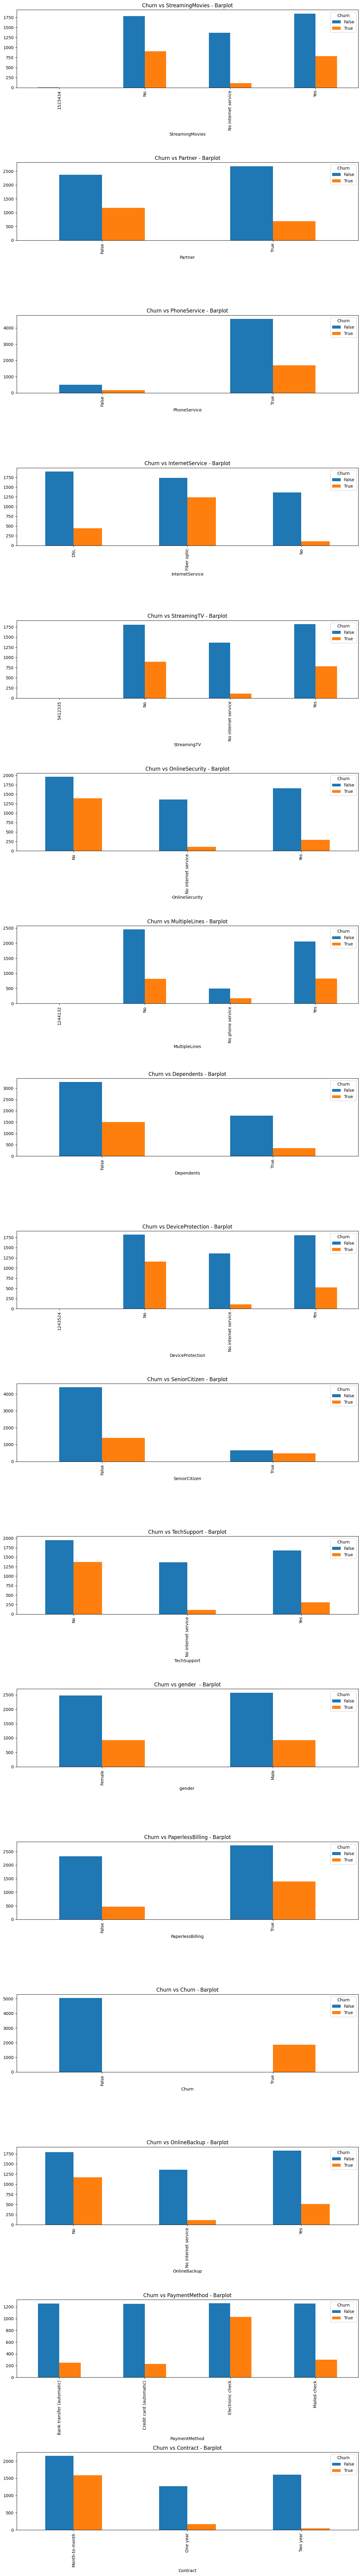

In [21]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 5 * max(len(cat_cols), 1)))

for i, col in enumerate(cat_cols):
    pd.crosstab(churn_df[col], churn_df["Churn"]).plot(
        kind="bar",
        ax=axes[i],
        title=f"Churn vs {col} - Barplot"
    )
plt.tight_layout()
plt.show()

In [22]:
target = churn_df["Churn"]

temp = churn_df.copy()
temp["Churn"] = temp["Churn"].apply(lambda x: 1 if x == True else 0).astype("float64")

for col in cat_cols:
    heatmap = (
        pd.crosstab(churn_df[col], target, margins=True)
        .style.background_gradient(cmap="coolwarm")
        .set_caption(f"Churn vs {col} Heatmap")
    )
    display(heatmap)
    display(temp.groupby(col, observed=True).agg({"Churn": "mean"}) * 100)

Churn,False,True,All
StreamingMovies,,,
1523434,1,0,1
No,1782,902,2684
No internet service,1363,108,1471
Yes,1847,781,2628
All,4993,1791,6784


,Churn
StreamingMovies,
1523434,0.00
No,33.61
No internet service,7.34
Yes,29.72


Churn,False,True,All
Partner,,,
False,2372,1174,3546
True,2682,684,3366
All,5054,1858,6912


,Churn
Partner,
False,33.11
True,20.32


Churn,False,True,All
PhoneService,,,
False,496,171,667
True,4558,1687,6245
All,5054,1858,6912


,Churn
PhoneService,
False,25.64
True,27.01


Churn,False,True,All
InternetService,,,
DSL,1901,446,2347
Fiber optic,1740,1238,2978
No,1365,109,1474
All,5006,1793,6799


,Churn
InternetService,
DSL,19.00
Fiber optic,41.57
No,7.39


Churn,False,True,All
StreamingTV,,,
5412335,1,0,1
No,1801,893,2694
No internet service,1361,109,1470
Yes,1819,784,2603
All,4982,1786,6768


,Churn
StreamingTV,
5412335,0.00
No,33.15
No internet service,7.41
Yes,30.12


Churn,False,True,All
OnlineSecurity,,,
No,1963,1389,3352
No internet service,1361,109,1470
Yes,1661,290,1951
All,4985,1788,6773


,Churn
OnlineSecurity,
No,41.44
No internet service,7.41
Yes,14.86


Churn,False,True,All
MultipleLines,,,
1244132,1,0,1
No,2455,817,3272
No phone service,496,169,665
Yes,2055,827,2882
All,5007,1813,6820


,Churn
MultipleLines,
1244132,0.00
No,24.97
No phone service,25.41
Yes,28.70


Churn,False,True,All
Dependents,,,
False,3269,1508,4777
True,1785,350,2135
All,5054,1858,6912


,Churn
Dependents,
False,31.57
True,16.39


Churn,False,True,All
DeviceProtection,,,
1243524,1,0,1
No,1817,1154,2971
No internet service,1359,108,1467
Yes,1805,526,2331
All,4982,1788,6770


,Churn
DeviceProtection,
1243524,0.00
No,38.84
No internet service,7.36
Yes,22.57


Churn,False,True,All
SeniorCitizen,,,
False,4392,1389,5781
True,662,469,1131
All,5054,1858,6912


,Churn
SeniorCitizen,
False,24.03
True,41.47


Churn,False,True,All
TechSupport,,,
No,1950,1372,3322
No internet service,1360,108,1468
Yes,1674,305,1979
All,4984,1785,6769


,Churn
TechSupport,
No,41.30
No internet service,7.36
Yes,15.41


Churn,False,True,All
gender,,,
Female,2477,930,3407
Male,2575,927,3502
All,5052,1857,6909


,Churn
gender,
Female,27.30
Male,26.47


Churn,False,True,All
PaperlessBilling,,,
False,2327,462,2789
True,2727,1396,4123
All,5054,1858,6912


,Churn
PaperlessBilling,
False,16.57
True,33.86


Churn,False,True,All
Churn,,,
False,5054,0,5054
True,0,1858,1858
All,5054,1858,6912


,Churn
Churn,
0.00,0.00
1.00,100.00


Churn,False,True,All
OnlineBackup,,,
No,1789,1173,2962
No internet service,1359,109,1468
Yes,1830,507,2337
All,4978,1789,6767


,Churn
OnlineBackup,
No,39.60
No internet service,7.43
Yes,21.69


Churn,False,True,All
PaymentMethod,,,
Bank transfer (automatic),1255,249,1504
Credit card (automatic),1249,226,1475
Electronic check,1261,1028,2289
Mailed check,1258,301,1559
All,5023,1804,6827


,Churn
PaymentMethod,
Bank transfer (automatic),16.56
Credit card (automatic),15.32
Electronic check,44.91
Mailed check,19.31


Churn,False,True,All
Contract,,,
Month-to-month,2149,1590,3739
One year,1272,165,1437
Two year,1603,49,1652
All,5024,1804,6828


,Churn
Contract,
Month-to-month,42.52
One year,11.48
Two year,2.97


El índice de deserción de la compañía de telecomunicaciones para las personas con contratos mes a mes es 4 veces mayor que el de las personas con contratos a un año, y 13 veces al de las personas con contrato para dos años.
También es curioso como el índice de deserción de las personas con el servicio de internet con fibra optica es 2 veces mayor al de las personas con servicio de internet DSL.

**Variables numericas vs Variables numericas**

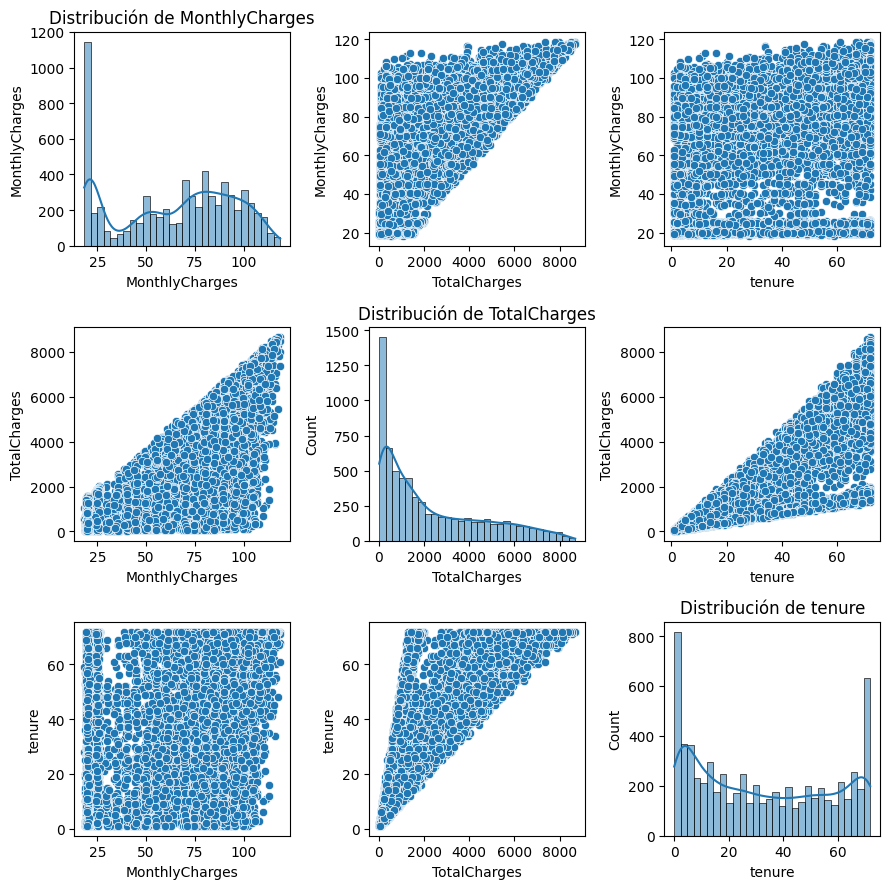

In [23]:
num_vars = len(num_cols)
fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=(3 * num_vars, 3 * num_vars))

for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        ax = axes[i, j]
        if i == j:
            sns.histplot(churn_df[col1], bins=30, kde=True, ax=ax)
            ax.set_title(f"Distribución de {col1}")
        else:
            sns.scatterplot(x=churn_df[col2], y=churn_df[col1], ax=ax)
        
        if j == 0:
            ax.set_ylabel(col1)
        if i == num_vars - 1:
            ax.set_xlabel(col2)
plt.tight_layout()
plt.show()

Estas graficas dejan conclusiones algo obvias que serían las siguientes: Mientras más meses lleve el usuario con los servisios activos mayor será la cuenta de todos los cobros por el servicio, y que mientras los cargos al mes sean más los cargos totales también lo serán.

**Variables categoricas vs Variables categoricas**

### 📈 **Multivariate Analysis**

**"PhoneService" vs "InternetService" vs "MultipleLines" vs "Churn"**

In [24]:
(
    churn_df[["PhoneService", "InternetService", "MultipleLines", "Churn"]]
    .groupby(["PhoneService", "InternetService", "MultipleLines"], observed=True)
    .agg(["count", "mean"])
)

Churn     
                                              count mean
PhoneService InternetService MultipleLines              
False        DSL             No phone service   662 0.25
True         DSL             No                1013 0.21
                             Yes                672 0.11
             Fiber optic     No                1106 0.45
                             Yes               1871 0.39
             No              1244132              1 0.00
                             No                1145 0.09
                             Yes                328 0.03

**"Contract" vs "PaymentMethod" vs "Churn"**

In [25]:
(
    churn_df[["Contract", "PaymentMethod", "Churn"]]
    .groupby(["Contract", "PaymentMethod"], observed=True)
    .agg(["count", "mean"])
)

Churn     
                                         count mean
Contract       PaymentMethod                       
Month-to-month Bank transfer (automatic)   577 0.33
               Credit card (automatic)     525 0.33
               Electronic check           1781 0.53
               Mailed check                854 0.32
One year       Bank transfer (automatic)   378 0.10
               Credit card (automatic)     388 0.11
               Electronic check            344 0.19
               Mailed check                327 0.07
Two year       Bank transfer (automatic)   548 0.03
               Credit card (automatic)     562 0.02
               Electronic check            164 0.08
               Mailed check                377 0.01

**Numericas vs Todas las variables numericas**

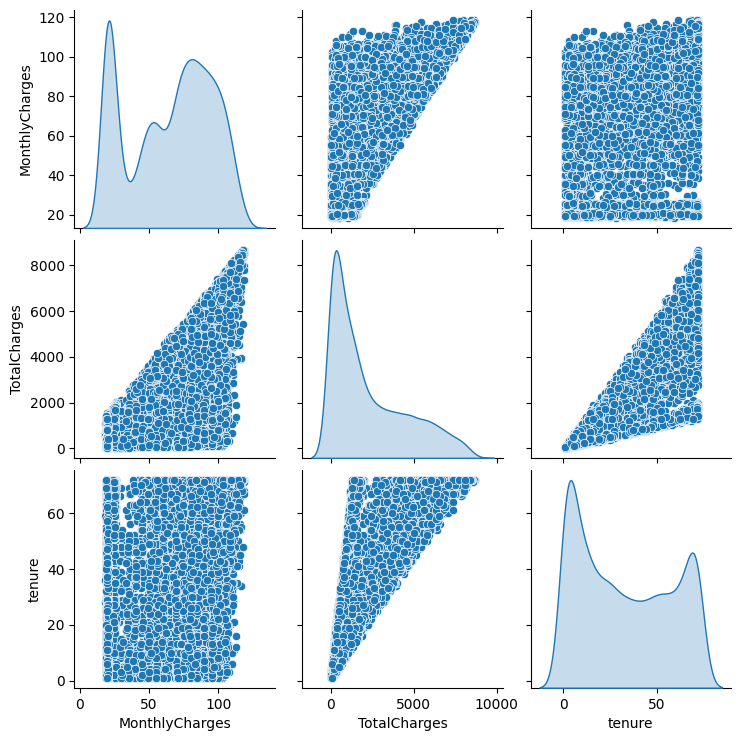

In [26]:
sns.pairplot(churn_df[num_cols], diag_kind="kde");

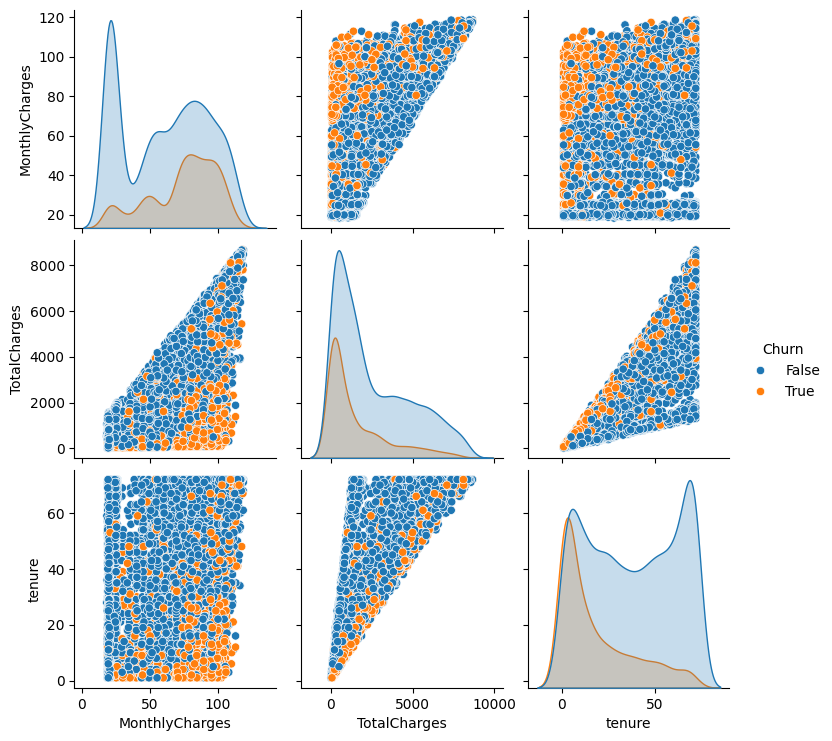

In [27]:
df = churn_df[[*num_cols, "Churn"]]

sns.pairplot(df, hue="Churn", diag_kind="kde");


## **Heuristica brevesita**

In [28]:
def determine_churn(row):
    if (
        row["PhoneService"] == True
        and row["MultipleLines"] == "No"
        and row["InternetService"] in ["DSL", "No"]
        and row["Contract"] in ["One year", "Two year"]
        and row["SeniorCitizen"] == False
        and row["PaymentMethod"] != "Electronic check"
    ):
        return False
    return True

In [29]:
test = churn_df.copy()
test = test.dropna()

test["heuristic_churn"] = test.apply(determine_churn, axis=1)

In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_true, y_pred = test["Churn"], test["heuristic_churn"]
accuracy_score(y_true, y_pred)

0.39693406756957883

In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.19      0.31      4946
        True       0.30      0.98      0.46      1773

    accuracy                           0.40      6719
   macro avg       0.64      0.58      0.39      6719
weighted avg       0.79      0.40      0.35      6719



In [32]:
confusion_matrix(y_true, y_pred)

array([[ 924, 4022],
       [  30, 1743]])

## 📊 **Analisis de los resultados y conclusiones**
- En este dataset es fácil predecir cuando un cliente no va a desertar del servicio pero es muy dificl predecir cuando si.
- Los clientes que tienen contratos de termino largos son las personas más propensas a retener el servicio.
- Hay algunas variables categoricas que poseen una categoria de más que es incorrecta y la debemos quitar en pasos siguientes.